## Predicting house prices in King County under 1 million 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb

## Import data

In [46]:
houses = pd.read_csv('kc_house_data.csv') #see readme file for info about the dataset
houses=houses.iloc[:,2:]
houses.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [23]:
houses.shape

(21613, 19)

In [24]:
houses.isnull().any().sum()

0

## Check for outliers and skewness

In [75]:
#correlation
houses.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248


sqft_above is highly correlated with sqft_living and grade \
sqft_living15 is highly correlated with sqft_living and grade \
sqft_lot15 is correlated with grade

In [25]:
# remove sqft_above, sqft_living15, sqft_lot15, yr_renovated
drop_list=['sqft_above','sqft_living15','yr_renovated','sqft_lot15']

for col in drop_list:
    houses=houses.drop([col], axis=1)

In [8]:
houses.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,98074,47.6168,-122.045


In [9]:
houses.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,291.509045,1971.005136,98077.939805,47.560053,-122.213896
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,442.575043,29.373411,53.505026,0.138564,0.140828
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,1951.000000,98033.000000,47.471000,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,1975.000000,98065.000000,47.571800,-122.230000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,560.000000,1997.000000,98118.000000,47.678000,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000


There is a house with 33 bedrooms, which is way above the mean and even 75th percentile. sqft_basement also seems to have large standard deviation.

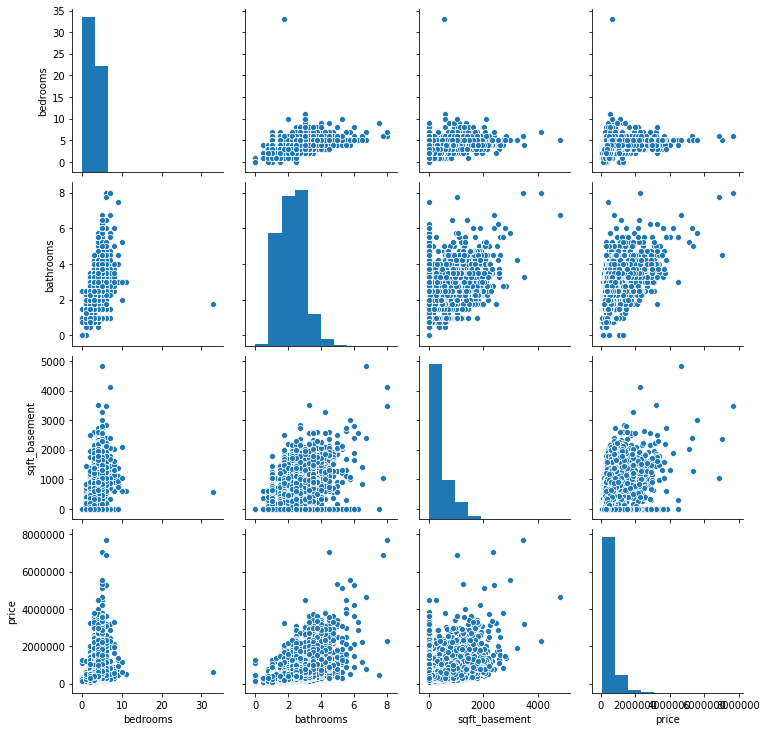

In [79]:
# Find outliers
features=houses[['bedrooms','bathrooms','sqft_basement','price']]
sns.pairplot(features,height=2.5)

There is a house entry with 33 bedrooms but only 2 bathrooms \
Most of the houses sold were sold for less than 1 million dollars \
sqft_basement is highly skewed 

In [80]:
#Find the outlier to investigate
houses[houses.values  == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,580,1947,98103,47.6878,-122.331


In [26]:
#This is most likely a typo so change to 3 bedrooms
houses['bedrooms'] = houses['bedrooms'].replace([33],3)

In [27]:
# check houses with zero bedrooms and bathrooms
houses[houses['bedrooms'].values  == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
875,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,0,1990,98102,47.6362,-122.322
3119,380000.0,0,0.00,1470,979,3.0,0,2,3,8,0,2006,98133,47.7145,-122.356
3467,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,0,1999,98125,47.7222,-122.290
4868,228000.0,0,1.00,390,5900,1.0,0,0,2,4,0,1953,98118,47.5260,-122.261
6994,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,0,1990,98053,47.6642,-122.069
8477,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,0,1985,98042,47.3473,-122.151
8484,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,0,2003,98038,47.3493,-122.053
9773,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,0,1990,98031,47.4095,-122.168
9854,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,0,1996,98065,47.5265,-121.828
12653,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,0,1999,98065,47.5261,-121.826


In [28]:
#remove houses with zero bedrooms and bathrooms
zero_bed=houses[houses['bedrooms'].values  == 0].index
houses=houses.drop(zero_bed)

In [29]:
zero_bath=houses[houses['bathrooms'].values  == 0].index
houses=houses.drop(zero_bath)

In [30]:
#Consider only houses sold under a million dollars
houses_under_mil=houses[houses['price']<1000000]

In [31]:
#Remove houses with sqft_basement 1.5x the IQR
q25,q75=houses_under_mil['sqft_lot'].describe()[4],houses_under_mil['sqft_lot'].describe()[6]
iqr=q75-q25

In [32]:
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off
print(lower,upper)

-2875.0 18125.0


In [33]:
houses_under_mil=houses_under_mil[houses_under_mil['sqft_lot']<20000]

In [34]:
houses_under_mil=houses_under_mil.reset_index()
houses_under_mil

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,98178,47.5112,-122.257
1,1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,98125,47.7210,-122.319
2,2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,98028,47.7379,-122.233
3,3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,98136,47.5208,-122.393
4,4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18116,21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,0,2009,98103,47.6993,-122.346
18117,21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,0,2014,98146,47.5107,-122.362
18118,21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,0,2009,98144,47.5944,-122.299
18119,21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,0,2004,98027,47.5345,-122.069


In [35]:
#transform latitude and longitude to a distance from epicenter using the harvesine formula
from haversine import haversine

seattle=[47.6092,-122.3363]
bellevue=[47.61555,-122.20392]

houses_under_mil['lat_long']=tuple(zip(houses_under_mil.lat,houses_under_mil.long))

In [36]:
seattle_dist=[]
for i in houses_under_mil['lat_long']:
    seattle_dist.append(haversine((seattle),(i)))
houses_under_mil['dist_from_seattle']=pd.Series(seattle_dist)

bellevue_dist=[]
for i in houses_under_mil['lat_long']:
    bellevue_dist.append(haversine((bellevue),(i)))
houses_under_mil['dist_from_bellevue']=pd.Series(bellevue_dist)

In [37]:
#Take the shortest distance from a major city as the distance from an epicenter
houses_under_mil['dist_from_epicenter']=houses_under_mil[['dist_from_seattle','dist_from_bellevue']].min(axis=1)

In [38]:
#create dummy variable from the first 4 digits in zipcode
houses_under_mil['zipcode'] = houses_under_mil['zipcode'].astype(str).str[0:4]
houses_under_mil = pd.get_dummies(houses_under_mil, columns=['zipcode'],prefix=['zip'],drop_first=True)

In [39]:
drop_list=['index','lat','long','lat_long']

for col in drop_list:
    houses_under_mil=houses_under_mil.drop([col], axis=1)
houses_under_mil

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zip_9810,zip_9811,zip_9812,zip_9813,zip_9814,zip_9815,zip_9816,zip_9817,zip_9818,zip_9819
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,0,0,1,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18116,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,1,0,0,0,0,0,0,0,0,0
18117,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,0,0,0,0,1,0,0,0,0,0
18118,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,...,0,0,0,0,1,0,0,0,0,0
18119,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0


In [40]:
houses_under_mil.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'dist_from_seattle',
       'dist_from_bellevue', 'dist_from_epicenter', 'zip_9801',
       'zip_9802', 'zip_9803', 'zip_9804', 'zip_9805', 'zip_9806',
       'zip_9807', 'zip_9809', 'zip_9810', 'zip_9811', 'zip_9812',
       'zip_9813', 'zip_9814', 'zip_9815', 'zip_9816', 'zip_9817',
       'zip_9818', 'zip_9819'], dtype=object)

## Standardise and split data

In [42]:
# Standardise the data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(houses_under_mil.iloc[:, np.r_[1:33]].values)
X = scaler.transform(houses_under_mil.iloc[:, np.r_[1:33]].values)

y = houses_under_mil.iloc[:,0].values

## K-fold cross validation

Random Forest Regressor

In [43]:
forest_regressor = RandomForestRegressor(max_depth=16,random_state=1)
cv = KFold(n_splits=4, shuffle=False)
cv_scores = cross_val_score(forest_regressor, X, y, cv=cv,scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv_scores)))
print(np.sqrt(np.abs(cv_scores)).mean())

[78814.39906319 77369.26859374 78938.62503765 80014.48711781]
78784.19495309857


XGBoost Regressor

In [49]:
xg_reg = xgb.XGBRegressor(booster='gbtree', learning_rate = 0.2,
                max_depth = 6, n_estimators = 150)
cv = KFold(n_splits=5, shuffle=False)
cv_scores = cross_val_score(xg_reg, X, y, cv=cv,scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv_scores)))
print(np.sqrt(np.abs(cv_scores)).mean())

[14:44:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[75337.71948112 73077.17597268 72756.32839361 71525.62982862
 76426.83036955]
73824.73680911546


XGBoost is better than random forest regressor in this case. \
We can expect a **mean squared error of around 74,000$** with the XGBoost model and a mean r^2 score of 0.85, the model is therefore adequate for estimating house prices under 1 million in King County